In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import pyross
import numpy as np
import matplotlib.pyplot as plt

# Introduction: Forecast for SIR model with stochastic parameters

In this notebook, we consider the SIIR model. 

We assume that the parameters 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of removal for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of removal for ymptomatic infected individuals) 

are not known exactly, but rather are characterized by a 4D Gaussian distribution with known mean and covariance matrix. The Gaussian distribution is truncated, i.e. set to zero if any of the parameters is $\leq 0$.

**We now illustrate how uncertainties in the parameters listed above affect the predictions of the SIR model.**

For this we simulate the SIR model $N_s = 500$ times; for each simulation the parameters are sampled from the given Gaussian distribution. The resulting 500 trajectories are shown together with their mean, standard deviation, median, and 5 as well as 95 percentiles.

We perform this analysis for 

1. the deterministic SIR model,
2. the stochastic SIR model (simulated with a Gillespie SSA algorithm), and
3. the stochastic SIR model (simulated with a tau-leaping algorithm).

# Define model parameters and initialise pyross.forecast.SIR

In [7]:
#Ex1: M=1, SIR

M = 1                  # the SIR model has no age structure
Ni = 50000*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

fsa   = 1              # the self-isolation parameter 

Ia0 = np.array([0])     # the SIR model has only one kind of infective 
Is0 = np.array([500])    # we take these to be symptomatic 
R0  = np.array([0])     # and assume there are no recovered individuals initially 
S0  = N-(Ia0+Is0+R0)    # so that the initial susceptibles are obtained from S + Ia + Is + R = N

# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

# duration of simulation and output datapoints
Tf = 100;  Nt=Tf+1



# These are the parameters that we sample stochastically
# means
alpha = 0.0            # fraction of asymptomatic infectives 
beta  = 0.5            # infection rate
gIa = 1/14.           # removal rate 
gIs = 1/14.           # removal rate 


#
cov = np.zeros([4,4],dtype=float)
cov[0,0] = 0.0*alpha # cov(alpha, alpha)
cov[1,1] = 0.02*beta # cov(beta, beta)
cov[2,2] = 0.001*gIa # cov(gIa, gIa)
cov[3,3] = 0.001*gIs # cov(gIs, gIs)
#
cov[1,2] = 0.001*beta # cov(beta, gIa)
cov[1,3] = 0.001*beta # cov(beta, gIs)
cov[2,1] = cov[1,2] # covariance matrix 
cov[3,1] = cov[1,3] # is symmetric
#
cov[2,3] = cov[2,2] # cov(gIa, gIs)
cov[3,2] = cov[2,3] # is symmetric
# setting cov(gIa, gIs) = cov(gIa, gIa) means that 
# we assume gIa and gIs to be equal, as
# will be visualised below


# Define parameters for simulations
parameters = {'alpha':alpha, 'beta':beta,'fsa':fsa,
             'gIa':gIa,'gIs':gIs,
             'cov':cov,
                }

# Initialise pyross forecast module
model_forecast = pyross.forecast.SIR(parameters, M, Ni)


# Number of simulations over which we average
Ns = 500 

In [8]:
# Define a function which we use below to plot simulation results
def plot_trajectories(result,
                percentile=-1,
                plot_index = 2, # which time series should be plotted? 
               filename='None'): # set filename for saving figures
    # plot_index = 0: susceptibles
    # plot_index = 1: infectives, asymptomatic
    # plot_index = 2: infectives, symptomatic
    if plot_index == 0:
        ylabel = r'$N_S$'
    elif plot_index == 1:
        ylabel = r'$N_{I,a}$'
    elif plot_index == 2:
        ylabel = r'$N_I$'
    else:
        raise RuntimeError("plot_index should be 0, 1, or 2.")
    #
    fontsize=25
    #
    #
    trajectories = result['X']
    t_arr = result['t']
    traj_mean = result['X_mean']
    traj_std = result['X_std']
    #
    #
    # Plot trajectories
    #
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(r'Simulation results for stochastic $\beta$, $\gamma$',
                 y=1.05,
                fontsize=fontsize)
    for i,e in enumerate(trajectories):
        ax.plot(t_arr,e[plot_index],
                alpha=0.15,
               )
    ax.fill_between(t_arr,traj_mean[plot_index] - traj_std[plot_index],
                    traj_mean[plot_index] + traj_std[plot_index],
                    alpha=0.7,
                    color='limegreen',
                           label='Std deviation')
    ax.plot(t_arr,traj_mean[plot_index] - traj_std[plot_index],
                    alpha=1,
            label='Std deviation',
            lw=1.5,
            ls='--',
                    color='black')
    ax.plot(t_arr,traj_mean[plot_index] + traj_std[plot_index],
                    alpha=1,
            #label='Std deviation',
            lw=1.5,
            ls='--',
                    color='black')
    ax.plot(t_arr,traj_mean[plot_index],
                    alpha=1,
            lw=2,
            color='black',
           label='Mean')
    ax.set_xlim(np.min(t_arr),np.max(t_arr))
    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
    ax.legend(loc='upper right',fontsize=18)
    plt.show(fig)
    if filename != 'None':
        fig.savefig(filename + '_trajs.png', bbox_inches='tight',dpi=100)
    plt.close(fig)
    #
    #
    #
    # Plot percentiles
    #
    if percentile > 0:
        percentiles_lower = np.percentile(trajectories[:,plot_index],percentile,axis=0)
        percentiles_upper = np.percentile(trajectories[:,plot_index],100-percentile,axis=0)
        percentiles_median = np.percentile(trajectories[:,plot_index],50,axis=0)
        print("In the following plot, red dashed lines denote {0} and {1} percentiles of the numerical data:".format(percentile,
                                                                                             100-percentile))
        fig, ax = plt.subplots(1,1,figsize=(7,5))
        ax.set_title(r'Simulation results for stochastic $\beta$, $\gamma$',
                     y=1.05,
                    fontsize=fontsize)
        for i,e in enumerate(trajectories):
            ax.plot(t_arr,e[plot_index],
                    alpha=0.15,
                   )
        ax.fill_between(t_arr,percentiles_lower,
                        percentiles_upper,
                        alpha=0.1,
                        color='red',
                               label='Percentiles')
        ax.plot(t_arr,percentiles_lower,
                        alpha=1,
                lw=2,
                label='Percentiles',
                ls='--',
                color='red',
               )
        ax.plot(t_arr,percentiles_upper,
                        alpha=1,
                lw=2,
                color='red',
                ls='--',
               )
        ax.plot(t_arr,percentiles_median,
                        alpha=1,
                lw=2,
                color='red',
               label='Median')
        ax.plot(t_arr,traj_mean[plot_index],
                        alpha=1,
                lw=2,
                color='black',
               label='Mean')
        ax.set_xlim(np.min(t_arr),np.max(t_arr))
        ax.set_ylabel(ylabel,fontsize=fontsize)
        ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
        ax.legend(loc='upper right',fontsize=18)
        plt.show(fig)
        if filename != 'None':
            fig.savefig(filename + '_trajs2.png', bbox_inches='tight',dpi=100)
        plt.close(fig)
        
        
# Define a function which we use below to plot parameters used for simulations
def plot_sample_parameters(result,
               filename='None'): # set filename for saving figures
    #
    fontsize=25
    #
    # Scatterplot of used parameters
    #
    sample_parameters = result['sample_parameters'].T
    beta = result['beta']
    gIa = result['gIa']
    gIs = result['gIs']
    #
    title = r'Samples for stochastic $\beta$, $\gamma_{I_a}$'
    labelx = r'$\beta $'
    labely = r'$\gamma_{I_a}$'
    x_mean = beta
    y_mean = gIa
    labelx_mean = r'$\langle \beta \rangle$'
    labely_mean = r'$\langle \gamma_{I_a} \rangle$'
    data_index_x = 1
    data_index_y = 2
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(title,y=1.05,fontsize=fontsize)
    ax.axvline(x_mean,color='limegreen',ls='--',lw=2,label=labelx_mean)
    ax.axhline(y_mean,color='dodgerblue',ls='--',lw=2,label=labely_mean)
    ax.scatter(sample_parameters[data_index_x], sample_parameters[data_index_y] ,
               label='sampled data',
               color='black',s=10) #, c = truth)
    ax.set_xlabel(labelx,fontsize=fontsize)
    ax.set_ylabel(labely,fontsize=fontsize)
    ax.set_xlim(0,1.05*np.max(sample_parameters[data_index_x]))
    ax.set_ylim(0,1.05*np.max(sample_parameters[data_index_y]))
    ax.legend(loc='best',fontsize=15)
    plt.show(fig)
    if filename != 'None':
        fig.savefig(filename + '_samples1.png', bbox_inches='tight',dpi=100)
    plt.close(fig)
    #
    #
    title = r'Samples for stochastic $\beta$, $\gamma_{I_s}$'
    labelx = r'$\beta $'
    labely = r'$\gamma_{I_s}$'
    x_mean = beta
    y_mean = gIs
    labelx_mean = r'$\langle \beta \rangle$'
    labely_mean = r'$\langle \gamma_{I_s} \rangle$'
    data_index_x = 1
    data_index_y = 3
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(title,y=1.05,fontsize=fontsize)
    ax.axvline(x_mean,color='limegreen',ls='--',lw=2,label=labelx_mean)
    ax.axhline(y_mean,color='dodgerblue',ls='--',lw=2,label=labely_mean)
    ax.scatter(sample_parameters[data_index_x], sample_parameters[data_index_y] ,
               label='sampled data',
               color='black',s=10) #, c = truth)
    ax.set_xlabel(labelx,fontsize=fontsize)
    ax.set_ylabel(labely,fontsize=fontsize)
    ax.set_xlim(0,1.05*np.max(sample_parameters[data_index_x]))
    ax.set_ylim(0,1.05*np.max(sample_parameters[data_index_y]))
    ax.legend(loc='best',fontsize=15)
    plt.show(fig)
    if filename != 'None':
        fig.savefig(filename + '_samples2.png', bbox_inches='tight',dpi=100)
    plt.close(fig)
    #
    #
    title = r'Samples for stochastic $\gamma_{I_a}$, $\gamma_{I_s}$'
    labelx = r'$\gamma_{I_a} $'
    labely = r'$\gamma_{I_s}$'
    x_mean = gIa
    y_mean = gIs
    labelx_mean = r'$\langle \gamma_{I_a} \rangle$'
    labely_mean = r'$\langle \gamma_{I_s} \rangle$'
    data_index_x = 2
    data_index_y = 3
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(title,y=1.05,fontsize=fontsize)
    ax.axvline(x_mean,color='limegreen',ls='--',lw=2,label=labelx_mean)
    ax.axhline(y_mean,color='dodgerblue',ls='--',lw=2,label=labely_mean)
    ax.scatter(sample_parameters[data_index_x], sample_parameters[data_index_y] ,
               label='sampled data',
               color='black',s=10) #, c = truth)
    ax.set_xlabel(labelx,fontsize=fontsize)
    ax.set_ylabel(labely,fontsize=fontsize)
    ax.set_xlim(0,1.05*np.max(sample_parameters[data_index_x]))
    ax.set_ylim(0,1.05*np.max(sample_parameters[data_index_y]))
    ax.legend(loc='best',fontsize=15)
    plt.show(fig)
    if filename != 'None':
        fig.savefig(filename + '_samples3.png', bbox_inches='tight',dpi=100)
    plt.close(fig)
    #

# 1. Forecast based on deterministic model

Finished. Time needed for evaluation: 00:00:02


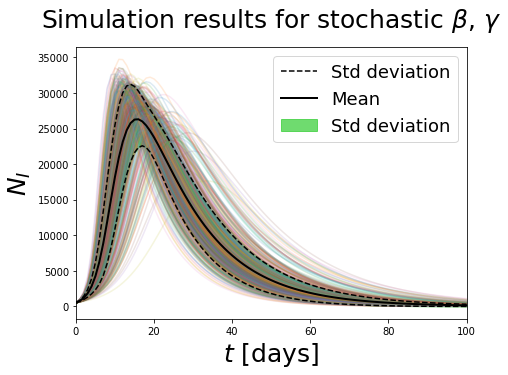

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


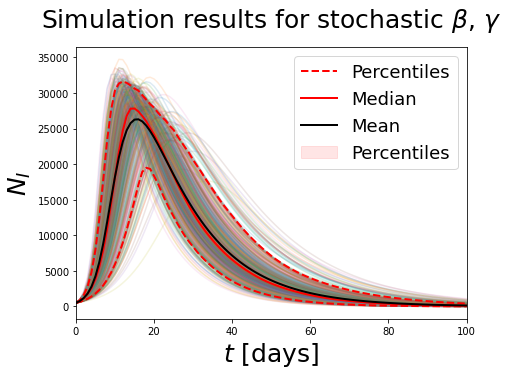

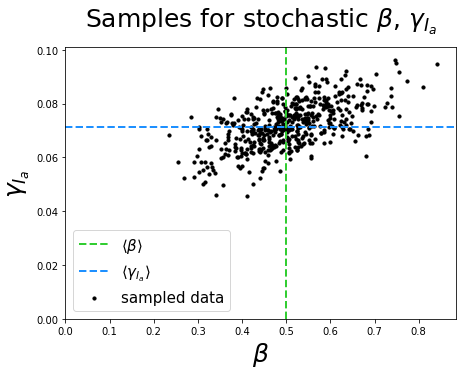

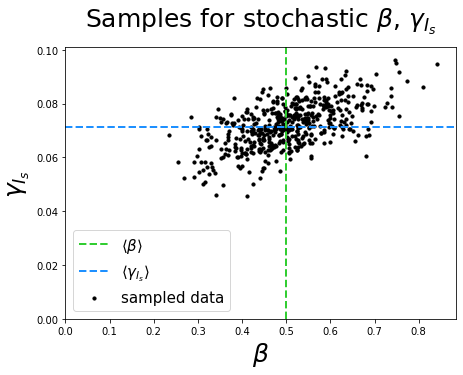

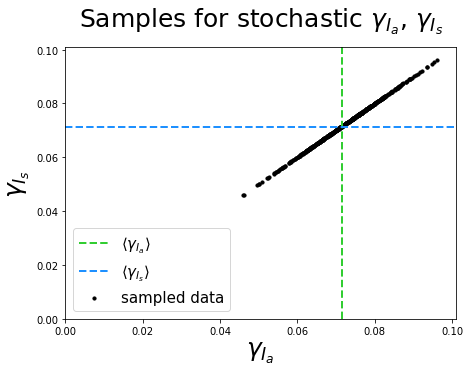

In [9]:
result = model_forecast.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt,
                                      verbose=True,
                                     Ns=Ns) 

plot_trajectories(result,
#            filename='forecast_deterministic',
            percentile=5,
           )

plot_sample_parameters(result)

As can be se seen in the last plot, and as defined in the covariance matrix used for the stochastic sampling, the  removal rates for asymptomatic and symptomatic infectives are identical for each simulation. That is also why the first two plots look identical.

# 2. Forecast based on stochastic Gillespie SSA algorithm

Finished. Time needed for evaluation: 00:56:18


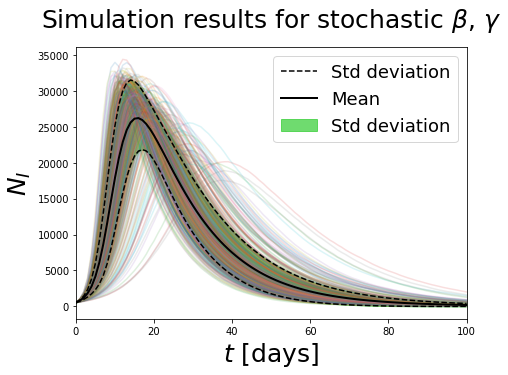

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


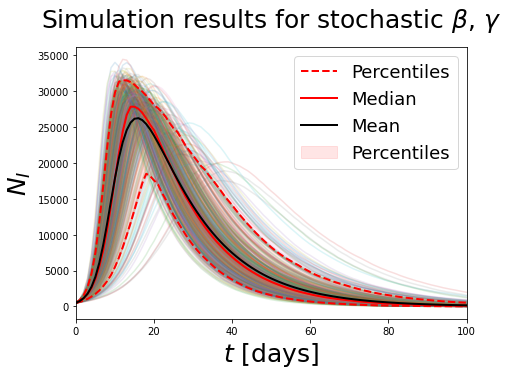

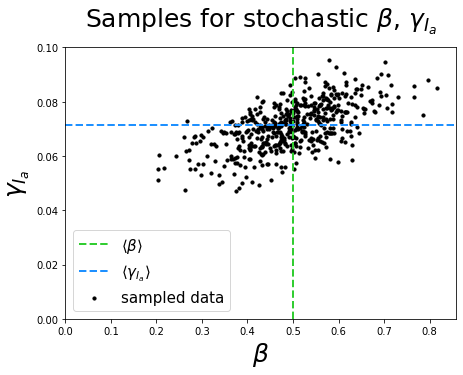

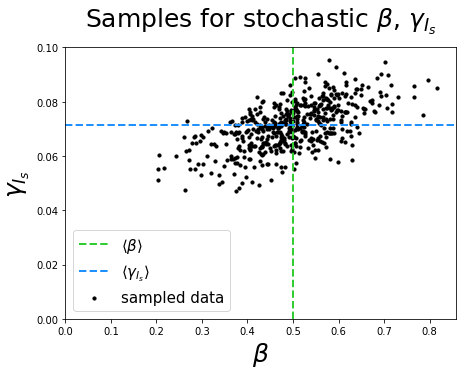

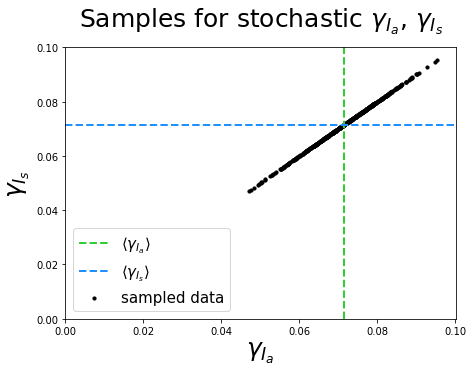

In [10]:
# This may taske a while
result = model_forecast.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt,
                                      verbose=True,
                                     method='gillespie',
                                     Ns=Ns) 

plot_trajectories(result,
#            filename='forecast_deterministic',
            percentile=5,
           )

plot_sample_parameters(result)

# 3. Forecast based on stochastic tau-leaping algorithm

Finished. Time needed for evaluation: 00:01:07


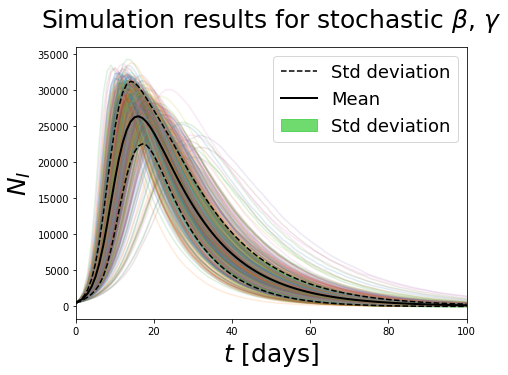

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


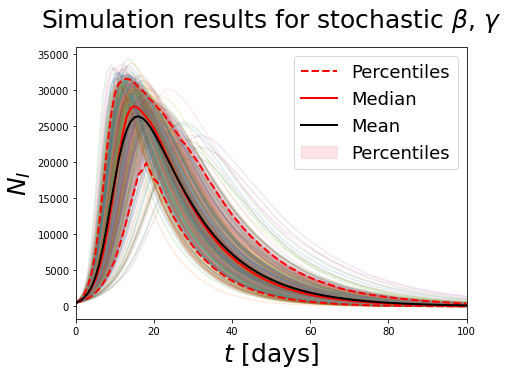

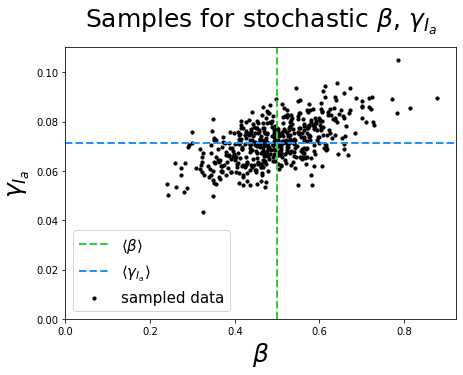

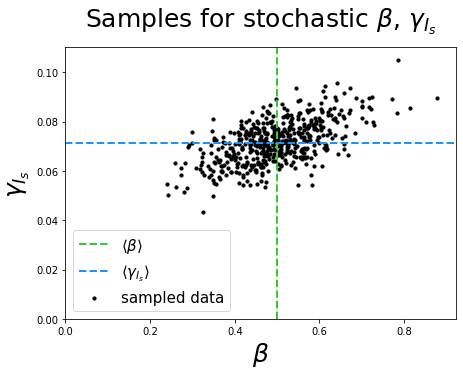

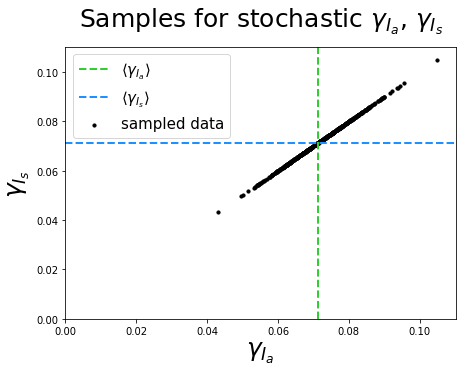

In [11]:
result = model_forecast.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt,
                                      verbose=True,
                                     method='tau-leaping',
                                     Ns=Ns)

plot_trajectories(result,
#            filename='forecast_deterministic',
            percentile=5,
           )

plot_sample_parameters(result)

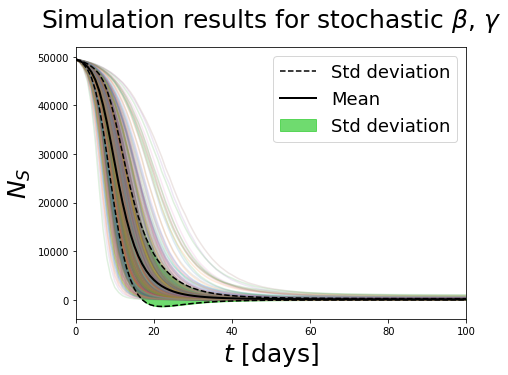

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


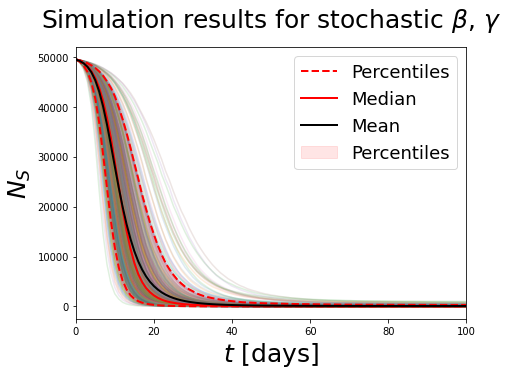

In [12]:
# For the stochastic tau-leaping algorithm, we also plot the time series for 
# the number of susceptibles

plot_trajectories(result,
#            filename='forecast_deterministic',
            plot_index =0,
            percentile=5,
           )